# Week 4 Programming Assignment 

Remark: 

Please upload your solutions of this assignment to Canvas with a file named "Programming_Assignment_4 _yourname.ipynb" before 11:59pm June 14.

=================================================================================================================

### Problem 1 (5 pts): Given a image $x$, use Pytorch to apply the following three operations to the image sequentially:

### (1) Do a convolution  $x_{conv1}= self.conv1(x)$ with $stride=1$,  zero $padding=2$ and  the $kernel_1$:
### $$
Kernel_1=\begin{bmatrix} 
0 & 0 & -1 & 0 & 0 \\                 
0&-1&-2&-1& 0\\
-1&-2&16&-2&-1\\
0&-1&-2&-1& 0\\
0& 0&-1& 0& 0 
\end{bmatrix}
$$

### (2) Do a ReLu $x_{relu} = F.relu(x_{conv1})$

### (3) Do another convolution  $x_{conv2}= self.conv2(x_{relu})$  with $stride=1$,  zero $padding=1$ and the average $kernel_2$:
### $$
Kernel_2=\begin{bmatrix} 
\frac{1}{9} & \frac{1}{9} &\frac{1}{9}  \\                 
\frac{1}{9} & \frac{1}{9} &\frac{1}{9}  \\                 
\frac{1}{9} & \frac{1}{9} &\frac{1}{9}  
\end{bmatrix}
$$
### Define a model which includes:  a convolutional layer self.conv1(), ReLu and another convolutional layer self.conv2(). Plot four images which are $x,~x_{conv1},~x_{relu},~x_{conv2}.$


Original image


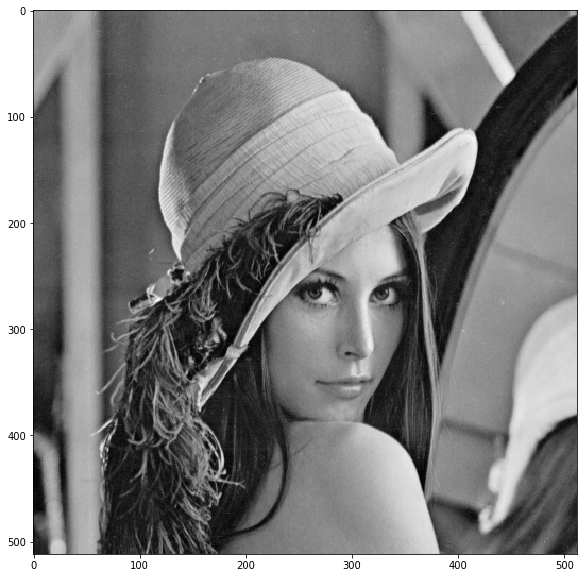

Apply the first convolution


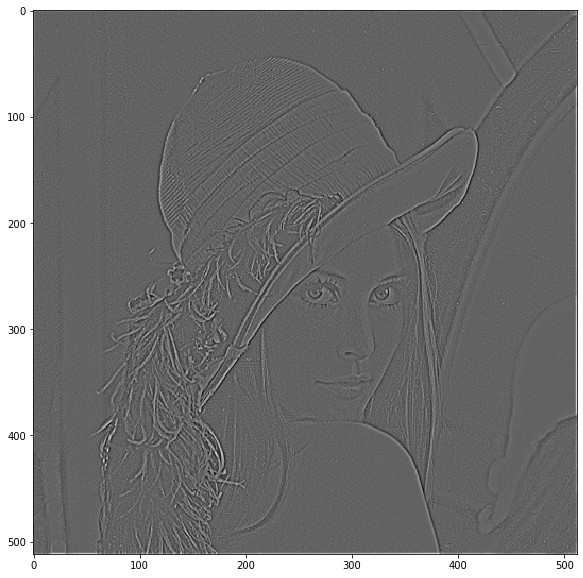

Apply the first convolution and ReLU


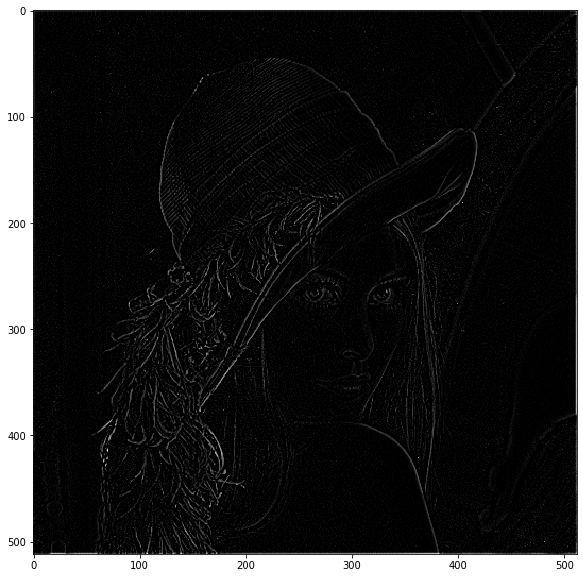

Apply the first convolution, ReLU and the second convolution


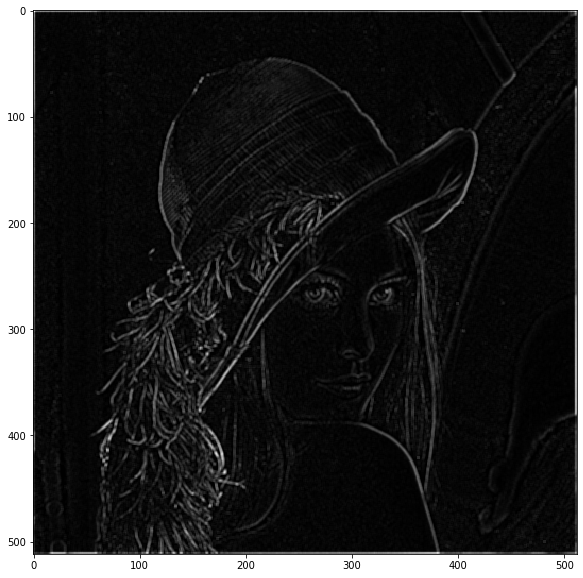

In [0]:
# You can finish the following code to solve Problem 1.
from PIL import Image
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
#Step I: Deal with the data
def read_image():    
    im = Image.open('./lena.png')
    im_array = np.array(im)
    # transfer im_array to 4th order torch.tensor 
    im_array=torch.from_numpy(im_array)
    im_array=im_array.reshape(1,1,im_array.size(0),im_array.size(1))
    im_array=im_array.type(torch.FloatTensor)
    return im_array

#Step II: Define a function to plot the image: give 4th order torch.tensor 

def plot_images(images):
    plt.rcParams["figure.figsize"]=10,10 # change the figure size for plotting
    images_for_plot = images[0,0,:,:] 
    plt.imshow(images_for_plot.detach().numpy(), cmap='gray') 
    plt.show()
    

#Step III: Define the operators
    
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        
        # Define the first convolutional layer
        kernel_1 = torch.tensor([[0., 0., -1., 0., 0.],[0., -1., -2., -1., 0.],[-1., -2., 16., -2., -1.],[0., -1., -2., -1., 0.],[0., 0., -1., 0., 0.]],dtype=torch.float32)
        # reshape your 2nd order tensor to 4th order tensor. Think about why?
        kernel_1 = kernel_1.reshape(1,1,kernel_1.size(0),kernel_1.size(1)) 
        self.conv1 = nn.Conv2d(1, 1, kernel_1.size(2), padding=2)
        # assign kerner_1 to conv1 layer.
        self.conv1.weight = torch.nn.Parameter(kernel_1)
        
        # Define the second convolutional layer
        kernel_2 = torch.tensor([[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]],dtype=torch.float32)
        # reshape your 2nd order tensor to 4th order tensor. Think about why?
        kernel_2 = kernel_2.reshape(1,1,kernel_2.size(0),kernel_2.size(1)) 
        self.conv2 = nn.Conv2d(1, 1, kernel_2.size(2), padding=1)
        # assign kerner_1 to conv1 layer.
        self.conv2.weight = torch.nn.Parameter(kernel_2)

    def forward(self, x):
        x_conv1 = self.conv1(x)
        x_relu = F.relu(self.conv1(x))
        x_conv2 = self.conv2(x_relu)
        return x_conv1,x_relu,x_conv2
    
#Step IV: Show results:
x=read_image()
my_model=model()
x_conv1,x_relu,x_conv2 = my_model(x)

print('Original image')
plot_images(x)
print('Apply the first convolution')
plot_images(x_conv1)
print('Apply the first convolution and ReLU')
plot_images(x_relu)
print('Apply the first convolution, ReLU and the second convolution')
plot_images(x_conv2)

=================================================================================================================

### **Problem 2 (5 pts).** Try to use stochastic gradient descent method to train CIFAR10 with LeNet-5 to achieve 60% test accuracy. Apply the following two strategies:

* ### Run 30 epochs, and divide the learning rate by 10 every 10 epochs
* ### Weight decay 
* ### Data normalization



### Print the results with the following format:

   "Epoch: i, Training accuracy: $a_i$, Test accuracy: $b_i$"

where $i=1,2,3,...$ means the $i$-th epoch,  $a_i$ and $b_i$ are the training accuracy and test accuracy computed at the end of $i$-th epoch.

In [2]:
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)

class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # change the input channels from 1 to 3
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.avg_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.avg_pool2d(out, 2)
        # out.size() = [batch_size, channels, size, size], -1 here means channels*size*size
        # out.view(out.size(0), -1) is similar to out.reshape(out.size(0), -1), but more efficient
        # Think about why we need to reshape the out?
        out = out.view(out.size(0), -1) 
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

minibatch_size = 15
num_epochs = 30
lr = 0.1

def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 10)  # epoch // 10, calculate the quotient 
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

# Step 1: Define a model
my_model =model()
if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, weight_decay = 0.0001)




# Step 3: load dataset

CIFAR10_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=CIFAR10_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=CIFAR10_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    current_lr = adjust_learning_rate(optimizer, epoch, lr)
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(images) 
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
        
    # Training accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()  
        outputs = my_model(images)
        p_max, predicted = torch.max(outputs, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    
    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()
        outputs = my_model(images)
        p_max, predicted = torch.max(outputs, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
        
    print('Epoch: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,training_accuracy,test_accuracy))  

Use GPU? True
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, the training accuracy: 0.3846, the test accuracy: 0.3834
Epoch: 2, the training accuracy: 0.4436, the test accuracy: 0.423
Epoch: 3, the training accuracy: 0.50552, the test accuracy: 0.4728
Epoch: 4, the training accuracy: 0.56022, the test accuracy: 0.5238
Epoch: 5, the training accuracy: 0.53654, the test accuracy: 0.4993
Epoch: 6, the training accuracy: 0.61298, the test accuracy: 0.5534
Epoch: 7, the training accuracy: 0.63214, the test accuracy: 0.563
Epoch: 8, the training accuracy: 0.63442, the test accuracy: 0.5664
Epoch: 9, the training accuracy: 0.63186, the test accuracy: 0.5574
Epoch: 10, the training accuracy: 0.55568, the test accuracy: 0.501
Epoch: 11, the training accuracy: 0.748, the test accuracy: 0.6232
Epoch: 12, the training accuracy: 0.76992, the test accuracy: 0.6294
Epoch: 13, the training accuracy: 0.7812, the test accuracy: 0.6328
Epoch: 14, the training accura

=================================================================================================================

### **Optional Problem 1.** Try to use stochastic gradient descent method to train MNIST with LeNet-5 to achieve 99% test accuracy. Apply the following two strategies:

* ### Run 20 epochs, and divide the learning rate by 10 every 10 epochs
* ### Weight decay 

### Print the results with the following format:

   "Epoch: i, Training accuracy: $a_i$, Test accuracy: $b_i$"

where $i=1,2,3,...$ means the $i$-th epoch,  $a_i$ and $b_i$ are the training accuracy and test accuracy computed at the end of $i$-th epoch.

=================================================================================================================

In [0]:
 current_lr = adjust_learning_rate(optimizer, epoch, lr)

### **Optional Problem 2.** Try to use stochastic gradient descent method to train CIFAR10 with a CNN to achieve 70% test accuracy. For the CNN model, you can modified the LeNet-5:

* ### Increase the number of out_channels in conv1 from 6 to 16 or more.
* ### Increase the number of out_channels in conv2 from 16 to 32 or more.  
* ### You will also need to change the size of fc1 layer.


Apply the following two strategies:

* ### Run 30 epochs, and divide the learning rate by 10 every 10 epochs
* ### Weight decay 
* ### Data normalization



### Print the results with the following format:

   "Epoch: i, Training accuracy: $a_i$, Test accuracy: $b_i$"

where $i=1,2,3,...$ means the $i$-th epoch,  $a_i$ and $b_i$ are the training accuracy and test accuracy computed at the end of $i$-th epoch.

